In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Setup
Start by defining the true function to be: $f(x) = -x^5 - x^3 + 2x$

We'll attempt to optimize this function in the range [-1,1]. The function is plotted below, and the true max is given by $x=0.632$

Much of this example is based on [https://arxiv.org/pdf/1807.02811.pdf] and [https://machinelearningmastery.com/what-is-bayesian-optimization/]. Go read the full tutorials to fill in any gaps that this notebook might miss.

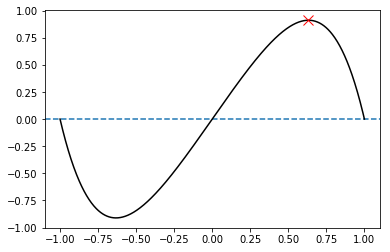

In [3]:
x = np.linspace(-1,1,1000)
y = -x**5 - x**3 + 2*x

max_y = y.max()
max_x = x[y.argmax()]

plt.axhline(ls='--')
plt.plot(x,y, color='k')
plt.plot(max_x, max_y, marker='x', color='red', markersize=10)
plt.show()

# Bayesian Optimization
The general idea with Bayesian Optimization is to optimize the function quickly in the case where $f(x)$ is computationally expensive to compute. The goal is to evaluate the function at the points that look most promising, which should reach a good approximation of the true max faster than random or exhaustive searching. To do this, we assume that the values $f(x)$ are drawn randomly from some prior probability distribution. We use all of the points where we have truely evaluated the function to define this distribution, and then find the point that with the largest expected improvement. That is, which point can we evaluate that may give us a value higher than our current max value? We then evaluate this point and update our prior. This runs repeatedly for a specified number of loops

# Estimation Loop
Here is where we begin approximating the function. The general idea for Bayesian optimization is to assume that the values $f(x)$ are drawn randomly from some prior probability distribution. For Gaussian Proccess regression (which is used here), this function is assumed to be a multivariate normal, with a particular mean vector and covariance matrix. 

We construct the mean vector by evaluating a mean function, $\mu_0$, at each sampled $x_i$. We construct the covariance matrix by evaluating a covariance function (called a kernel) $\Sigma_0$, at each pair of points $x_i, x_j$. The values $f(x)$ are then given by:

$$f(x_{1:k}) \sim \text{Normal}\Big( \mu_0(x_{1:k}),\Sigma_0(x_{1:k}, x_{1:k}) \Big)$$

where $x_{1:k}$ represents the sequence $[x_1, \ldots, x_k]$, $\mu_0(x_{1:k}) = [\mu_0(x_1), \ldots, \mu_0(x_k)]$, $f(x_{1:k}) = [f(x_1), \ldots, f(x_k)]$, and $\Sigma_0(x_{1:k}, x_{1:k}) = [\Sigma_0(x_{1}, x_{1}), \ldots, \Sigma_0(x_{1}, x_{k}); \ldots ; \Sigma_0(x_{k}, x_{1}), \ldots, \Sigma_0(x_{k}, x_{k})]$.

Suppose we observe $f(x_{1:n})$ and want to infer the value of $f(x)$ at some new point $x$. We can compute the conditional distribution of $f(x)$ to be:

$$f(x) | f(x_{1:n}) \sim \text{Normal} \Big( \mu_n(x), \sigma^2_n(x) \Big)$$
$$\mu_n(x) = \Sigma_0(x, x_{1:n}) \Sigma_0(x_{1:n}, x_{1:n})^{-1} \Big( f(x_{1:n}) - \mu_0(x_{1:n}) \Big) + \mu_0(x)$$
$$\sigma^2_n(x) = \Sigma_0(x,x) - \Sigma_0(x,x_{1:n})\Sigma_0(x_{1:n},x_{1:n})^{-1}\Sigma_0(x_{1:n},x)$$

Rather than computing the above directly, it's often faster to use a Cholesky decomposition and solve the system of linear equations, but for this example we'll use the above. Additionally, we'll add a constant of $10^{-6}$ to each element along the diagonal of $\Sigma_0(x_{1:n}, x_{1:n})$ to prevent the eigenvalues from approaching 0.

## Mean Function
For this example we'll use a constant mean function:
$$\mu_0(x) = \mu$$

## Kernel
The kernel is used to give points that are close in the input space a high positive correlation. It helps to smooth the function and prevent large, unexpected jumps in the estimation.

For this example we'll use a power exponential or Gaussian kernel:

$$\Sigma_0(x,x') = \alpha_0 \text{ exp}(-||x - x'||^2)$$
$$||x-x'||^2 = \sum_{i=1}^d\alpha_i(x_i-x'_i)^2$$

## Choosing Hyperparameters
The above functions contain parameters (typically called hyperparameters) that must be chosen correctly to accurately represent the observed data. We denote the vector of parameters $\eta$, and for the example above we have: $\eta = [\alpha_{0:d}, \mu]$. To choose the hyperparameters, we set $\eta$ to the value that maximizes the likelihood of our observations under our prior:

$$\hat \eta = \underset{\eta}{\text{argmax}} \ P \Big( f(x_{1:n}) | \eta \Big)$$

## Acquisition Function
For this example we use the Expected Improvement (EI) function. Suppose we have observed $n$ points already. Let $f_n^* = \max_{i \leq n} f(x_i)$. The improvement for a new point $x$ is $f(x) - f_n^* \text{ if } f(x) \gt f_n^*, \text{ else } 0$. We can write this more compactly as $[f(x) - f_n^*]^+$ where $a^+ = \max(a,0)$. Since $f(x)$ is unknown, we define the expected improvement to be:

$$EI_n(x) :=  E_n\Big[ [f(x) - f_n^*]^+ \Big]$$

Where $E_n[\cdot] = E[\cdot | x_{1:n}, y_{1:n}]$ is the expectation taken under the distribution given the previous observations. Our next point to evaluate is then given by:

$$x_{n+1} = \underset{x}{\text{argmax}}\ EI_n(x)$$

# An Attempt at Implementation

(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)


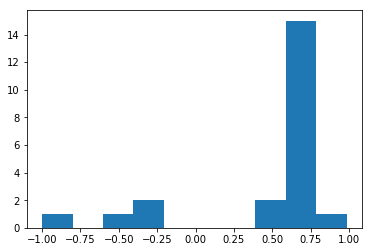

array([0.63313862])

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from warnings import catch_warnings, simplefilter


def f(x):
    """Objective function for this example."""
    return -x**5 - x**3 + 2*x


def expected_improvement(X, X_sample, y_sample, model):
    """Return EI at each point in X.
    
    Computes EI at points X based on sampled data X_sample and Y_sample
    """
    with catch_warnings():
        # Ignore some weird sklearn errors in prediction
        simplefilter("ignore")
        mu, sigma = model.predict(X, return_std=True)  # Get mean and variance at X
        opt = y_sample.max()  # Current optimal
        sigma = sigma.reshape(-1,1)

        imp = mu - opt  # Improvement is the mean for a given x minus the current optimal
        Z = imp / sigma  # Convert that to a z-score
        
        print(Z.shape)
        
        # This basically integrates from -inf up to Z and factors in the probability of actually
        # getting the improvement value imp. We want the optimal expected improvement not just the 
        # highest best-case improvement.
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)  
        ei[sigma == 0.0] = 0.0

        return ei
    

def opt_acquisition(X_sample, y_sample, model, n_surrogate):
    """Returns the X sample that optimizes the acquisition function"""
    X = np.random.uniform(-1,1,n_surrogate).reshape(-1,1)
    scores = expected_improvement(X, X_sample, y_sample, model)
    return X[scores.argmax()]


def bayes_opt(objective, n_random, n_bayes, n_surrogate=100):
    """Perform Bayesian optimization on the objective function.
    
    Args:
        objective(function): The objective function to maximize.
        n_random(int): The number of random samples to gather before
            starting the bayesian optimization loops.
        n_bayes(int): The number of Bayesian optimization loops to run.
        n_surrogate(int, optional): The number of random samples to evaluate
            on the surrogate model before evaluating the best option on the 
            objective function. Default 100.
            
    Returns:
        List of length n_inputs containing the inputs to the objective function
        that maximizes the return value.
    """
    X_sample = np.random.uniform(-1,1,n_random).reshape(-1,1)
    y_sample = objective(X_sample)
        
    model = GaussianProcessRegressor()
    
    for _ in range(n_bayes):
        # Fit model to current data
        model.fit(X_sample, y_sample)
        
        # Find next x that optimizes expected improvement
        x = opt_acquisition(X_sample, y_sample, model, n_surrogate)
        
        # Evaluate that x
        y = objective(x)
        
        X_sample = np.vstack((X_sample, x))
        y_sample = np.vstack((y_sample, y))
        
    plt.hist(X_sample)
    plt.show()
    return X_sample[y_sample.argmax()]
    
        
bayes_opt(f, 2, 20)